# Biophysical Modeling of Land Surface Temperature in Lagos Using Random Forest
This notebook documents the data preprocessing, model development, and analysis pipeline for predicting Land Surface Temperature (LST) across Lagos using Random Forest regression and multisource remote sensing data.


## 1. Import Libraries and Environment Setup

## 2. Data Import and Preprocessing
This section handles reading raster predictors, extracting valid pixels, and cleaning the dataset for Random Forest modeling.

## 3. Model Development (Random Forest Models 1–3)
This section defines, trains, and evaluates three Random Forest models with progressive predictor inclusion.

## 4. Model Evaluation and Feature Importance
Model performance metrics (R², RMSE, MAE) and feature importance scores are computed and visualized here.

## 5. Partial Dependence Plots
PDPs illustrate the marginal effect of key predictors (NDVI, NDBI, Built_pct, Albedo) on predicted LST.

## 6. Spatial Prediction and Validation
The best-performing model (Model 3) is applied to the Lagos raster stack for spatial LST prediction. Residual and scatter plots are also generated.

## 7. Visualization and Map Outputs
Plots include feature importance charts, correlation matrices, and boxplots comparing LST across LULC types.

## 8. Summary and Export
All model results, figures, and rasters are exported for inclusion in the main paper and supplementary materials.

In [ ]:
# Cleaned and structured code will be organized here following the defined workflow.


### 1.1 Imports and Environment
This cell imports required Python libraries and prints versions for reproducibility.

In [1]:
# Imports
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.impute import SimpleImputer
from joblib import dump, load

# Print package versions for reproducibility
print('numpy:', np.__version__)
print('pandas:', pd.__version__)
print('rasterio:', rasterio.__version__)
print('geopandas:', gpd.__version__)
print('scikit-learn:', __import__('sklearn').__version__)


numpy: 1.24.3
pandas: 2.3.2
rasterio: 1.3.6
geopandas: 1.1.1
scikit-learn: 1.3.0


### 2. File paths, band mapping and parameters
Set file paths and the band order for the raster stack.

In [2]:
# File paths and parameters
os.chdir(r"c:\peter\SDM_data\Nigeria\Lagos")
stack_path = "Lagos_full_stack_100m.tif"  # multiband stack containing predictors and LST
output_csv = "Lagos_RF_input_data.csv"
outputs_dir = "outputs"
os.makedirs(outputs_dir, exist_ok=True)

# Band mapping (confirm this order before running)
band_map = {
    1: 'lst_l8',
    2: 'lst_modis',
    3: 'ndvi',
    4: 'canopy',
    5: 'built_pct',
    6: 'pop_100m',
    7: 'elevation',
    8: 'ndbi',
    9: 'lulc',
    10: 'albedo'
}

# Predictors for Model 3
predictors = ['ndvi', 'canopy', 'built_pct', 'elevation', 'ndbi', 'lulc', 'albedo']
target = 'lst_l8'

print('Stack path:', stack_path)
print('Output CSV:', output_csv)
print('Outputs dir:', outputs_dir)
print('Predictors:', predictors)


Stack path: Lagos_full_stack_100m.tif
Output CSV: Lagos_RF_input_data.csv
Outputs dir: outputs
Predictors: ['ndvi', 'canopy', 'built_pct', 'elevation', 'ndbi', 'lulc', 'albedo']


### 3. Extract raster stack to CSV
Read the multiband raster, flatten bands, and save a cleaned CSV including coordinates.

In [3]:
# Read raster stack and extract values with coordinates
with rasterio.open(stack_path) as src:
    stack = src.read()  # shape: (bands, rows, cols)
    profile = src.profile
    transform = src.transform
    height = src.height
    width = src.width
    print(f'Loaded raster with {src.count} bands, size {width}x{height}')

# Build dictionary of flattened bands
data = {}
for i in range(stack.shape[0]):
    bname = band_map.get(i+1, f'band_{i+1}')
    arr = stack[i].astype(float)
    data[bname] = arr.flatten()

# Create coordinate arrays for centers of pixels
rows_idx, cols_idx = np.indices((height, width))
xs, ys = rasterio.transform.xy(transform, rows_idx, cols_idx)
xs = np.array(xs).flatten()
ys = np.array(ys).flatten()
data['lon'] = xs[:len(data[next(iter(data))])]  # safe slice
data['lat'] = ys[:len(data[next(iter(data))])]

df = pd.DataFrame(data)
print('Initial df shape (flattened):', df.shape)

# Replace common NoData values and infinities with NaN
df = df.replace([-9999, 0, np.inf, -np.inf], np.nan)

# Relaxed filtering: keep rows with at least (number_of_bands - 3) valid values
max_missing = 3
df = df[df.isna().sum(axis=1) <= max_missing]

# Drop rows that are completely empty or missing target
df = df.dropna(subset=[target])

print('DataFrame shape after cleaning:', df.shape)

# Save CSV (only predictors + target + coords)
cols_to_save = predictors + [target, 'lon', 'lat']
df[cols_to_save].to_csv(output_csv, index=False)
print('Saved cleaned CSV to', output_csv)


Loaded raster with 10 bands, size 1829x374
Initial df shape (flattened): (684046, 12)
DataFrame shape after cleaning: (321853, 12)
Saved cleaned CSV to Lagos_RF_input_data.csv


### 4. Prepare data for modeling
Load CSV, impute missing predictor values, and split into train/test sets.

In [4]:
# Load CSV
df = pd.read_csv(output_csv)
print('Loaded CSV shape:', df.shape)

# Drop rows missing target
df = df.dropna(subset=[target])

# Features and target
X = df[predictors].copy()
y = df[target].copy()

# Simple mean imputation for remaining NaNs in predictors
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train-test split (spatial randomness not enforced here; user used spatial CV during tuning)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)


Loaded CSV shape: (321853, 10)
Train size: (257482, 7) Test size: (64371, 7)


### 5. Model Training (Models 1–3)
Train three Random Forest models with the specified predictor sets and save them.

In [5]:
# Common RF parameters (can be tuned further)
rf_params = {
    'n_estimators': 500,
    'max_depth': 25,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1
}

# Define models' predictor sets
model_defs = {
    'Model1': ['ndvi', 'canopy'],
    'Model2': ['ndvi', 'canopy', 'built_pct', 'elevation'],
    'Model3': predictors  # full set
}

models = {}
metrics = {}

for mname, feats in model_defs.items():
    print('\nTraining', mname, 'with features:', feats)
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train[feats], y_train)
    # Save model
    model_path = os.path.join(outputs_dir, f"{mname}_RF_model.joblib")
    dump(rf, model_path)
    models[mname] = rf
    # Evaluate on test set
    y_pred = rf.predict(X_test[feats])
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    metrics[mname] = {'r2': r2, 'rmse': rmse, 'mae': mae}
    print(f"{mname} -- R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Save metrics to a CSV for table generation
metrics_df = pd.DataFrame(metrics).T.reset_index().rename(columns={'index':'model'})
metrics_df.to_csv(os.path.join(outputs_dir, 'model_performance_summary.csv'), index=False)
print('Saved model performance summary to outputs directory.')



Training Model1 with features: ['ndvi', 'canopy']
Model1 -- R2: 0.5113, RMSE: 2.4443, MAE: 1.7493

Training Model2 with features: ['ndvi', 'canopy', 'built_pct', 'elevation']
Model2 -- R2: 0.6582, RMSE: 2.0441, MAE: 1.4255

Training Model3 with features: ['ndvi', 'canopy', 'built_pct', 'elevation', 'ndbi', 'lulc', 'albedo']
Model3 -- R2: 0.7438, RMSE: 1.7700, MAE: 1.2094
Saved model performance summary to outputs directory.


### 6. Feature Importance and Partial Dependence (Model 3)
Generate variable importance plot and PDPs for selected features.

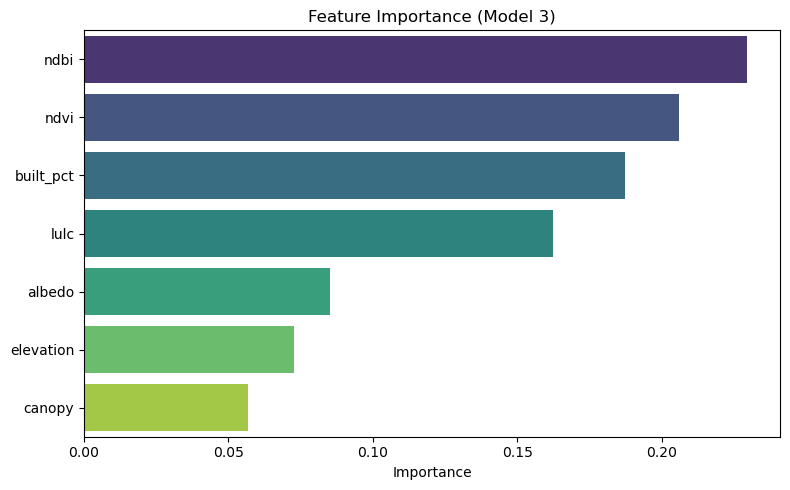

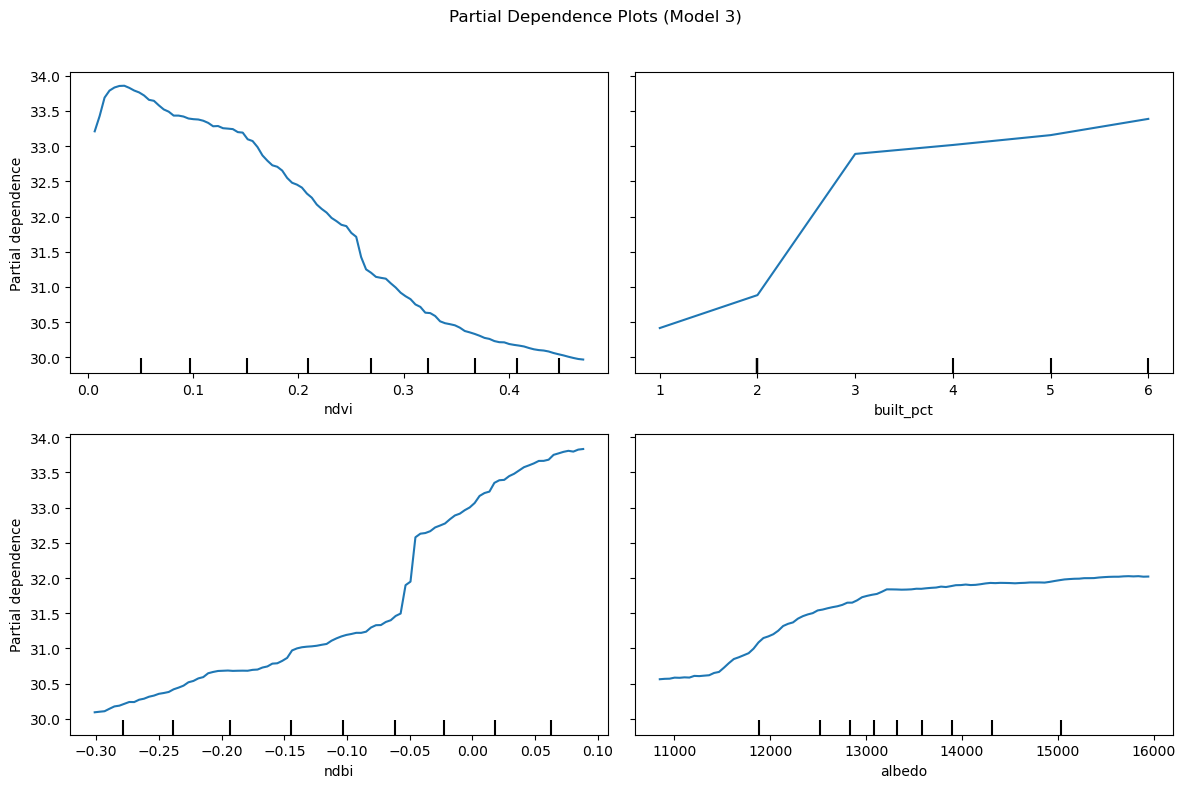

In [6]:
# Feature importance for Model3
model3 = models['Model3']
importances = model3.feature_importances_
feat_imp = pd.Series(importances, index=model_defs['Model3']).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title('Feature Importance (Model 3)')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig(os.path.join(outputs_dir, 'feature_importance_model3.png'), dpi=300)
plt.show()

# Partial Dependence Plots for key variables
pdp_features = ['ndvi', 'built_pct', 'ndbi', 'albedo']
fig, ax = plt.subplots(2,2, figsize=(12,8))
PartialDependenceDisplay.from_estimator(model3, X_imputed, pdp_features, kind='average', grid_resolution=100, ax=ax)
plt.suptitle('Partial Dependence Plots (Model 3)')
plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig(os.path.join(outputs_dir, 'PDP_composite_model3.png'), dpi=300)
plt.show()


### 7. Spatial Prediction and Residual Mapping (Model 3)
Apply Model 3 to the raster stack to produce predicted LST and residual rasters.

In [7]:
# Apply Model 3 to full raster stack and save predicted raster
model3 = models['Model3']
with rasterio.open(stack_path) as src:
    meta = src.meta.copy()
    meta.update({'count':1, 'dtype':'float32'})
    rows = src.height
    cols = src.width

    # Prepare array to store predictions
    pred_arr = np.full((rows, cols), np.nan, dtype='float32')
    residual_arr = np.full((rows, cols), np.nan, dtype='float32')

    # Read predictor bands indices
    band_indices = {v:k for k,v in band_map.items()}

    # Process in blocks to conserve memory
    window_size = 512
    for i in range(0, rows, window_size):
        for j in range(0, cols, window_size):
            h = min(window_size, rows - i)
            w = min(window_size, cols - j)
            window = rasterio.windows.Window(j, i, w, h)
            data_block = src.read([band_indices[b] for b in model_defs['Model3']], window=window).astype(float)
            # data_block shape: (n_bands, h, w)
            n_bands = data_block.shape[0]
            flat_block = data_block.reshape(n_bands, -1).T  # (h*w, n_bands)
            df_block = pd.DataFrame(flat_block, columns=model_defs['Model3'])
            # Impute missing values with training imputer (mean)
            df_block = df_block.replace([-9999, np.inf, -np.inf], np.nan)
            df_block = df_block.fillna(X_imputed.mean())  # simple fill
            # Predict
            preds = model3.predict(df_block)
            preds = preds.reshape(h, w)
            pred_arr[i:i+h, j:j+w] = preds.astype('float32')

    # Save predicted raster
    out_pred_path = os.path.join(outputs_dir, 'Predicted_LST_Model3_100m.tif')
    with rasterio.open(out_pred_path, 'w', **meta) as dst:
        dst.write(pred_arr, 1)
    print('Saved predicted raster to', out_pred_path)


Saved predicted raster to outputs\Predicted_LST_Model3_100m.tif


### 8. Observed vs Predicted Scatter Plot and Residual Analysis (Model 3)
Generate scatter plot using test set and compute final metrics.

Model 3 test metrics: R2=0.7438, RMSE=1.7700, MAE=1.2094


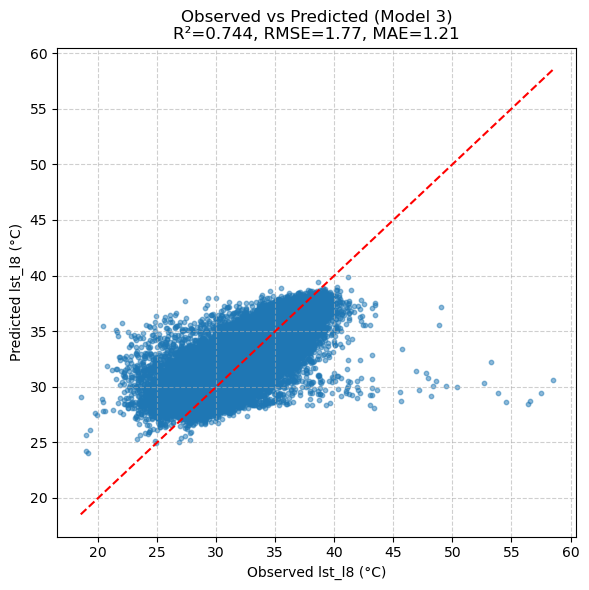

In [8]:
# Predict on test set using Model3 features
y_pred_test = model3.predict(X_test[model_defs['Model3']])
r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
print(f'Model 3 test metrics: R2={r2:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}')

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, s=10, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Observed lst_l8 (°C)')
plt.ylabel('Predicted lst_l8 (°C)')
plt.title(f'Observed vs Predicted (Model 3)\nR²={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(outputs_dir, 'Scatter_Model3_TestSet.png'), dpi=300)
plt.show()


### 9. LST by LULC Boxplot
Generate boxplot of predicted lst_l8 across LULC classes.

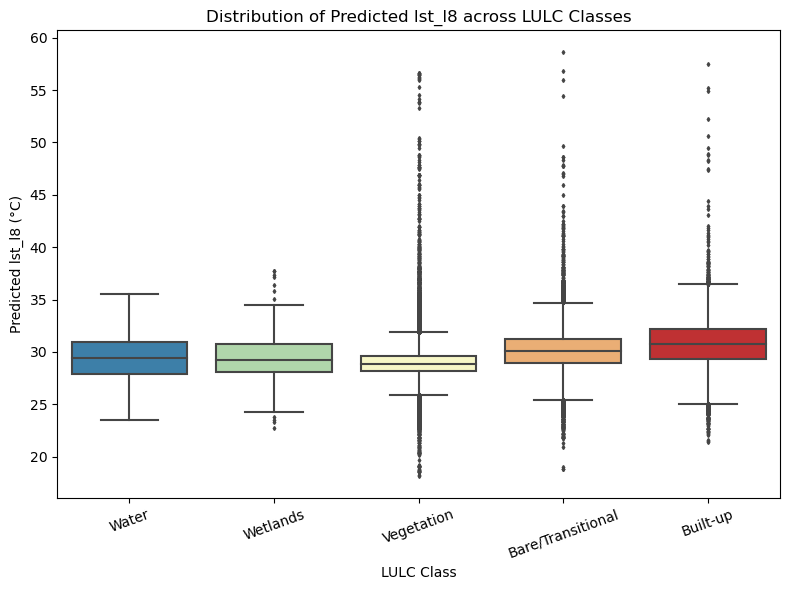

In [9]:
# Load cleaned CSV with coords (if present)
df = pd.read_csv(output_csv)

# Use lst_l8 (target) and map lulc to grouped classes if needed
df = df.dropna(subset=['lulc', 'lst_l8'])

def classify_lulc(val):
    # Adjust mapping to your LULC coding scheme
    if val in [1,2,3]:
        return 'Water'
    elif val in [4,5,6]:
        return 'Wetlands'
    elif val in [7,8,9,10]:
        return 'Vegetation'
    elif val in [11,12,13,14]:
        return 'Bare/Transitional'
    elif val in [15,16,17,18,19]:
        return 'Built-up'
    else:
        return 'Other'

df['LULC_Class'] = df['lulc'].apply(classify_lulc)
order = ['Water','Wetlands','Vegetation','Bare/Transitional','Built-up']
palette = sns.color_palette(["#2b83ba", "#abdda4", "#ffffbf", "#fdae61", "#d7191c"])
plt.figure(figsize=(8,6))
sns.boxplot(x='LULC_Class', y='lst_l8', data=df, order=order, palette=palette, fliersize=2)
plt.xlabel('LULC Class')
plt.ylabel('Predicted lst_l8 (°C)')
plt.title('Distribution of Predicted lst_l8 across LULC Classes')
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(os.path.join(outputs_dir, 'LST_by_LULC_Boxplot.png'), dpi=300)
plt.show()


### 10. Correlation Matrix (Supplementary Figure S2)

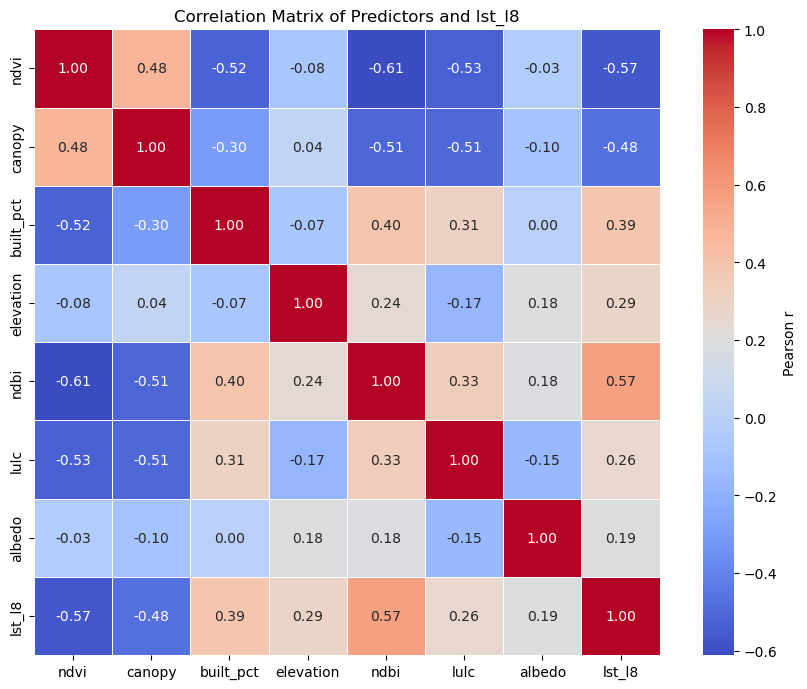

In [10]:
df_subset = df[predictors + [target]].dropna()
corr = df_subset.corr()
plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, square=True, cbar_kws={'label':'Pearson r'})
plt.title('Correlation Matrix of Predictors and lst_l8')
plt.tight_layout()
plt.savefig(os.path.join(outputs_dir, 'Correlation_Matrix_lst_l8.png'), dpi=300)
plt.show()


### 11. Export summary and artifacts
Save summary files and list outputs for supplementary materials.

In [11]:
# Save model performance and feature importance
metrics_df = pd.DataFrame(metrics).T
metrics_df.to_csv(os.path.join(outputs_dir, 'model_metrics_table.csv'))

feat_imp.to_csv(os.path.join(outputs_dir, 'feature_importance_model3.csv'))

# List produced files
print('Outputs saved in', outputs_dir)
for fname in os.listdir(outputs_dir):
    print('-', fname)


Outputs saved in outputs
- Correlation_Matrix_lst_l8.png
- feature_importance_model3.csv
- feature_importance_model3.png
- LST_by_LULC_Boxplot.png
- Model1_RF_model.joblib
- Model2_RF_model.joblib
- Model3_RF_model.joblib
- model_metrics_table.csv
- model_performance_summary.csv
- PDP_composite_model3.png
- Predicted_LST_Model3_100m.tif
- Scatter_Model3_TestSet.png


### Supplementary Outputs – Model 1 and Model 2 Predictions”

In [ ]:
import rasterio
import numpy as np
import joblib
from rasterio.transform import from_origin
from tqdm import tqdm

# Load saved models
model1 = joblib.load("outputs/Model1_RF_model.joblib")
model2 = joblib.load("outputs/Model2_RF_model.joblib")

# Define predictor band indices (1-based indexing for rasterio)
bands_model1 = [3, 4]  # NDVI, Canopy
bands_model2 = [3, 4, 5, 7]  # NDVI, Canopy, Built_pct, Elevation

# Input raster stack
stack_path = "Lagos_full_stack_100m.tif"

# Output filenames
output_model1 = "outputs/Predicted_Model1_LST.tif"
output_model2 = "outputs/Predicted_Model2_LST.tif"

def predict_rf_to_raster(model, band_indices, input_raster, output_path):
    with rasterio.open(input_raster) as src:
        meta = src.meta.copy()
        width, height = src.width, src.height

        # Read required predictor bands
        predictors = np.stack([src.read(band) for band in band_indices], axis=-1)
        predictors = predictors.reshape(-1, predictors.shape[-1])

        # Handle NaNs or invalid values
        mask = np.any(np.isnan(predictors), axis=1)
        predictors[mask] = 0  # temporary fill

        # Predict LST
        print(f"Generating predictions for {output_path} ...")
        y_pred = np.zeros(predictors.shape[0])
        chunk_size = 50000  # process in chunks to manage memory

        for i in tqdm(range(0, len(predictors), chunk_size)):
            chunk = predictors[i:i+chunk_size]
            y_pred[i:i+chunk_size] = model.predict(chunk)

        # Reshape predictions back to raster grid
        y_pred = y_pred.reshape((height, width))

        # Write output raster
        meta.update(dtype=rasterio.float32, count=1)
        with rasterio.open(output_path, "w", **meta) as dst:
            dst.write(y_pred.astype(rasterio.float32), 1)
        print(f"Saved: {output_path}")

# Run predictions
predict_rf_to_raster(model1, bands_model1, stack_path, output_model1)
predict_rf_to_raster(model2, bands_model2, stack_path, output_model2)


### Residual Maps (Figures S3–S4)

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_residual_map_from_stack(full_stack_path, predicted_path, observed_band, title, filename):
    # Read observed LST (Band 1 = lst_l8) from full stack
    with rasterio.open(full_stack_path) as src:
        observed = src.read(observed_band).astype(float)
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
    # Read predicted raster (Model 1 or Model 2)
    with rasterio.open(predicted_path) as pred:
        predicted = pred.read(1).astype(float)
    
    # Compute residual (Observed - Predicted)
    residual = observed - predicted

    # Mask NaNs or invalid values
    residual = np.where(np.isnan(residual), np.nan, residual)
    
    # Consistent color range for both maps
    vmin, vmax = -10, 10  # adjust range based on your data spread
    
    # Plot residual map
    plt.figure(figsize=(6, 5))
    img = plt.imshow(residual, cmap="RdBu_r", extent=extent, vmin=vmin, vmax=vmax)
    plt.colorbar(img, label="Residual (Observed - Predicted, °C)")
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"Saved: {filename}")

# Run for Model 1 and Model 2
plot_residual_map_from_stack(
    full_stack_path="Lagos_full_stack_100m.tif",
    predicted_path="outputs/Predicted_Model1_LST.tif",
    observed_band=1,  # lst_l8
    title="Residual Map - Model 1",
    filename="outputs/Figure_S3_Residual_Model1.png"
)

plot_residual_map_from_stack(
    full_stack_path="Lagos_full_stack_100m.tif",
    predicted_path="outputs/Predicted_Model2_LST.tif",
    observed_band=1,  # lst_l8
    title="Residual Map - Model 2",
    filename="outputs/Figure_S4_Residual_Model2.png"
)


### Correlation Matrix (File S2)

In [ ]:
import pandas as pd

# Assuming df is your dataframe with predictor columns
corr_matrix = df.corr()  # Compute correlation
corr_matrix.to_csv("outputs/File_S2_CorrelationMatrix.csv", index=True)
